In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [81]:
# #extracting residuals standardization
# train_data_tot = pd.read_csv("train_24.csv")
# test_data_tot = pd.read_csv("test_24.csv")

# #sampling the train_data
# #train_data_tot = train_data_tot.sample(frac=1)

# # taking only features for normalization
# train_data = train_data_tot[['x','y']]
# test_data = test_data_tot[['x','y']].to_numpy()

# #splitting the train data into train and validation data
# validation_data = train_data[400:].to_numpy()
# train_data = train_data[0:400].to_numpy()

# #train data normalization
# train_mean = np.mean(train_data,0)
# train_data = np.array([i-train_mean for i in train_data])
# x = len(train_data)
# train_data = train_data/(np.var(train_data,0)*(400/399))**0.5
# train_data = pd.DataFrame(train_data,columns = ['x','y'])
# train_data['label'] = list(train_data_tot['label'][0:400].values)

# #test data normalization
# test_mean = np.mean(test_data,0)
# test_data = np.array([i-test_mean for i in test_data])
# x = len(test_data)
# test_std = (np.var(test_data,0)*(100/99))**0.5
# test_data = (test_data/test_std)
# test_data = pd.DataFrame(test_data,columns = ['x','y'])
# test_data['label'] = list(test_data_tot['label'].values)

# #validation data normalization
# validation_mean = np.mean(validation_data,0)
# validation_data = np.array([i-validation_mean for i in validation_data])
# x = len(validation_data)
# validation_data = validation_data/(np.var(validation_data,0)*(100/99))**0.5
# validation_data = pd.DataFrame(validation_data,columns = ['x','y'])
# validation_data['label'] = list(train_data_tot['label'][400:].values)

In [82]:
#min-max scaling normalization

train_data_tot = pd.read_csv("train_24.csv")
test_data = pd.read_csv("test_24.csv").to_numpy()

# train_data = train_data.sample(frac=1)

validation_data = train_data_tot[375:].to_numpy()
train_data = train_data_tot[0:375].to_numpy()

#normalizing the train data
train_max = np.amax(train_data,0)
train_min = np.amin(train_data,0)
train_data = np.array([(i-train_min)/(train_max-train_min) for i in train_data])
train_data = pd.DataFrame(train_data, columns = ['x','y','label'])
train_data['label'] = train_data['label']*2

#normalizing the test data
test_max = np.amax(test_data,0)
test_min = np.amin(test_data,0)
test_data = np.array([(i-test_min)/(test_max-test_min) for i in test_data])
test_data = pd.DataFrame(test_data, columns = ['x','y','label'])
test_data['label'] = test_data['label']*2

#normalizing the validation data
validation_max = np.amax(validation_data,0)
validation_min = np.amin(validation_data,0)
validation_data = np.array([(i-validation_min)/(validation_max-validation_min) for i in validation_data])
validation_data = pd.DataFrame(validation_data, columns = ['x','y','label'])
validation_data['label'] = validation_data['label']*2


In [83]:
class KNN_classifier:
  def __init__(self,k):
    self.k = k
    self.feature = None
    self.label = None

  def distance(self,a,b):
    return np.sqrt(np.sum(np.square(np.subtract(a,b))))

  def set_k(self,k):
    self.k = k

  #finds the most probable label among all the labels
  def probable_label(self, features, labels, position):

    dist = [self.distance(position,i) for i in features]
    temp = []
    for i in range(len(labels)):
      temp.append((dist[i],features[i],labels[i]))
    temp = sorted(temp,key=lambda x:x[0])

    count = self.k
    store = []
    
    for i in temp:
      _,_,ans = i
      store.append(ans)
      count-=1
      if count==0:
        break

    label_count = {}#dictionary maintaning label count of each label
    for i in store:
      if i in label_count.keys():
        label_count[i] = label_count[i]+1
      else:
        label_count[i] = 1
    
    fin_label = 0 #maximum label
    count = 0
    for i in label_count.keys():
      if label_count[i]>count:
        count = label_count[i]
        fin_label = i
    return fin_label


  def fit(self, features, labels):

    feature = features.to_numpy(dtype = 'float32')
    label = labels.to_numpy(dtype = 'float32')
    label = label.flatten()

    self.feature = feature
    self.label = label

    train_labels = [self.probable_label(feature,label,i) for i in feature]

    return train_labels
  
  def predict(self,features):
    prediction = [self.probable_label(self.feature, self.label, i) for i in features]
    return prediction


In [84]:
def build_model(k):

  model = KNN_classifier(k)

  return model
  pass

def train_model(model, data, features, labels):

  train_fit = model.fit(data[features],data[labels])
  
  return train_fit
  pass

In [85]:
#reference for plotting : https://www.tutorialspoint.com/graph-k-nn-decision-boundaries-in-matplotlib
def plot(model, features, label, k, test_feature, test_labels):

  plt.xlabel("x")
  plt.ylabel("y")

  x_min,x_max = features[:,0].min()-0.1, features[:,0].max()+0.1
  y_min,y_max = features[:,1].min()-0.1, features[:,1].max()+0.1
  xx,yy = np.meshgrid(np.arange(x_min,x_max,0.01),np.arange(y_min,y_max,0.01)) #change according to requirement
  z = np.array(model.predict(np.c_[xx.ravel(),yy.ravel()]))
  z = z.reshape(xx.shape)

  #palette = ['mocassin','lightsteelblue'] , palette = ['orange','cyan'] , palette = ['darkorange','c']
  plt.contourf(xx, yy, z,alpha=0.25)
  plt.contour(xx, yy, z, colors='k', linewidths=0.7)
  sns.scatterplot(x = test_feature[:,0], y = test_feature[:,1], hue = test_labels)

  plt.xlim(xx.min(),xx.max())
  plt.ylim(yy.min(),yy.max())

  plt.title("3-class classification (k = %i)"%(k))
  plt.show()
  pass

def confusion_matrix(predict,original):
  n = len(np.unique(np.array(original)))
  x = np.zeros((n,n))
  for i in range(len(predict)):
    x[int(original[i])][int(predict[i])]+=1
  return x
  pass

def accuracy(predict,original):
  ans = 0
  for i in range(len(predict)):
    if predict[i] == original[i]:
      ans+=1
  return ans/len(predict)
  pass

In [86]:
#build and train the model
for i in range(20):
  model = build_model(i)
  train_fit = train_model(model, train_data, ['x','y'], ['label'])
  features = ['x','y']
  label = ['label']

  tr_label = train_data[label].to_numpy(dtype = 'float32').flatten()
  te_label = validation_data[label].to_numpy(dtype = 'float32').flatten()
  tr_feature = train_data[features].to_numpy(dtype = 'float32')
  te_feature = validation_data[features].to_numpy(dtype = 'float32')

  test_fit = model.predict(te_feature)
  print(accuracy(train_fit,tr_label))
  print(accuracy(test_fit,te_label)) 
  print(" ")

1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
0.992
 
1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
1.0
 
1.0
0.992
 
1.0
0.992
 
1.0
0.992
 
1.0
0.992
 
1.0
0.992
 
1.0
1.0
 
1.0
0.992
 
1.0
0.992
 
1.0
0.992
 


In [87]:
k = 1
model = build_model(k)
train_fit = train_model(model, train_data, ['x','y'], ['label'])

In [88]:
#testing the model

features = ['x','y']
label = ['label']

tr_label = train_data[label].to_numpy(dtype = 'float32').flatten()
te_label = test_data[label].to_numpy(dtype = 'float32').flatten()
tr_feature = train_data[features].to_numpy(dtype = 'float32')
te_feature = test_data[features].to_numpy(dtype = 'float32')

test_fit = model.predict(te_feature)

In [89]:
# accuracy of the model on test and train data
print(accuracy(train_fit,tr_label))
print(accuracy(test_fit,te_label))

1.0
1.0


<Axes: title={'center': 'test confusion matrix'}>

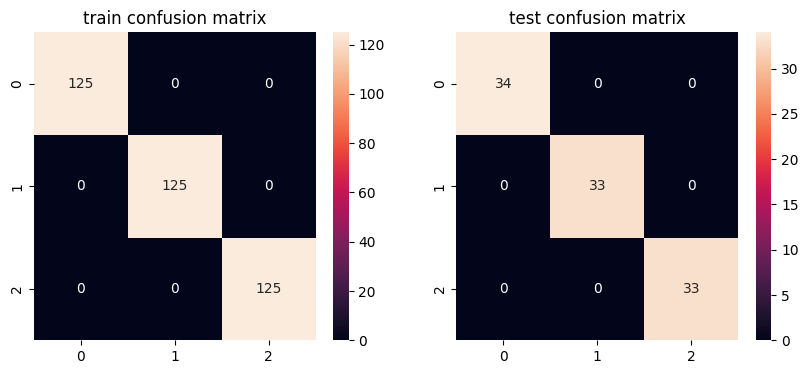

In [90]:
# confusion matrices of test and train data
a = confusion_matrix(train_fit, tr_label)
b = confusion_matrix(test_fit, te_label)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.set_title('train confusion matrix')
ax2.set_title('test confusion matrix')
sns.heatmap(a, ax=ax1, annot=True, fmt='g')
sns.heatmap(b, ax=ax2, annot=True)

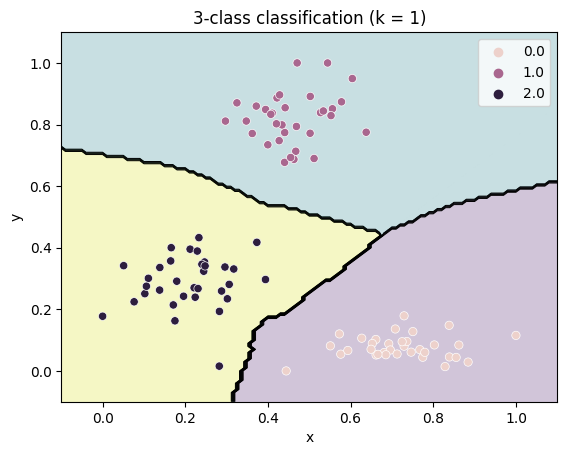

In [91]:
#plotting the data
plot(model, tr_feature, tr_label, k, te_feature, test_fit)